In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
all_label = pd.read_csv('../training_solutions_rev1.csv')

In [3]:
all_label.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [4]:
label_0_3 = all_label.values[:,0:3]

In [5]:
label_0_3[:,1:][label_0_3[:,1:]>0.5] = 1
label_0_3[:,1:][label_0_3[:,1:]<0.5] = 0
label_0_3 = label_0_3.astype(np.int)

In [6]:
#cut figures
#for row in label_0_3[:,0]:
#    p = '../images_training_rev1/'+str(row)+'.jpg'     
#    data=Image.open(p)
#    box=(142,142,282,282)
#    roi=data.crop(box)
#    roi.save('../cut_images/'+str(row)+'.jpg')

In [7]:
#load data
def load_data():
    rows = label_0_3[:,0]
    lenth = len(rows)
    data = np.empty((lenth,140,140,3),dtype="float32")
    for i in range(lenth):
        img = Image.open("../cut_images/"+ str(rows[i]) + ".jpg" )
        arr = np.asarray(img,dtype = "float32")
        data[i,:,:,:] = arr
    data =data/ np.max(data)
    data =data- np.mean(data)
    return data

In [8]:
data_all = load_data()

In [9]:
data_all.shape

(61578, 140, 140, 3)

In [10]:
import matplotlib.pyplot as plt

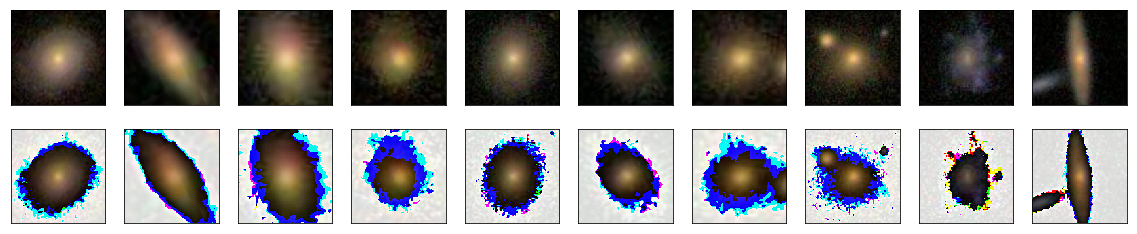

In [11]:
plt.figure(figsize=(20, 4))
n=10
for i in range(n):
    #original fig
    img = Image.open("../cut_images/"+ str(label_0_3[:,0][i]) + ".jpg" )
    ax = plt.subplot(2,n,i+1)
    plt.imshow((img))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #standard fig
    ax = plt.subplot(2,n,i+n+1)
    plt.imshow((data_all[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Task one:
Classification

In [12]:
train_data = data_all[:10000]
train_label = label_0_3[:10000,1:]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
train_label = np.mat(train_label)
print(train_data.shape[0], ' samples')

train_data.shape: (10000, 140, 140, 3)
train_label.shape: (10000, 2)
10000  samples


In [132]:
model = Sequential()

model.add(Conv2D(10,(3,3),padding='same',input_shape=(140,140,3),activation='relu',data_format='channels_last'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(20,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(40,(3,3),padding='same',activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Dropout(0.25))

#model.add(BatchNormalization())
model.add(Conv2D(40,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))


model.add(Dense(2))
model.add(Activation('sigmoid'))


adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0000001)
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
#tensorboard = TensorBoard(log_dir='./logs/run_BN', histogram_freq=0)
#checkpoint = ModelCheckpoint('model_CIFAR_run1.h5',monitor = 'val_acc',verbose = 1,save_best_only = True)
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])


#调用fit方法，就是一个训练过程. 训练的epoch数设为10，batch_size为100．
#数据经过随机打乱shuffle=True。verbose=1，训练过程中输出的信息，0、1、2三种方式都可以，无关紧要。show_accuracy=True，训练时每一个epoch都输出accuracy。
#validation_split=0.2，将20%的数据作为验证集。
model.fit(train_data, train_label, 
          batch_size=50, 
          nb_epoch=300,
          shuffle=True,
          verbose=1,
          validation_split=0.2, 
          callbacks=[EarlyStopping])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8000 samples, validate on 2000 samples
Epoch 1/300
8000/8000 [==============================] - 13s - loss: 0.5883 - acc: 0.6086 - val_loss: 0.6521 - val_acc: 0.5560
Epoch 2/300
8000/8000 [==============================] - 12s - loss: 0.5087 - acc: 0.7574 - val_loss: 0.6462 - val_acc: 0.5560
Epoch 3/300
8000/8000 [==============================] - 12s - loss: 0.4704 - acc: 0.7699 - val_loss: 0.5829 - val_acc: 0.6630
Epoch 4/300
8000/8000 [==============================] - 12s - loss: 0.4558 - acc: 0.7770 - val_loss: 0.5161 - val_acc: 0.7210
Epoch 5/300
8000/8000 [==============================] - 11s - loss: 0.4463 - acc: 0.7831 - val_loss: 0.4761 - val_acc: 0.7865
Epoch 6/300
8000/8000 [==============================] - 12s - loss: 0.4395 - acc: 0.7859 - val_loss: 0.4685 - val_acc: 0.7930
Epoch 7/300
8000/8000 [==============================] - 12s - loss: 0.4314 - acc: 0.7887 - val_loss: 0.4568 - val_acc: 0.7950
Epoch 8/300
8000/8000 [==============================] - 12s - 

# Results for classification task

I tried to use several hyperparameter combos with other technics.

Seems like accuracy of 80% is a limit

# Now use Autoencoder


In [54]:
batch_size = 100
latent_dim = 3
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 140*140

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(140,140,3))


x = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*5*5,activation='relu')(h_3)
h_5 = Reshape((5,5,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='valid',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='valid',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [66]:
if USE == 'vae':
    vae.fit(train_data[:1000], train_data[:1000],  
            shuffle=True,  
            nb_epoch=nb_epoch,    
            batch_size=100,  
            validation_data=(train_data[1000:1500],train_data[1000:1500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:1000], train_data[:1000],  
            shuffle=True,  
            nb_epoch=nb_epoch,  
            batch_size=200,  
            validation_data=(train_data[1000:1500],train_data[1000:1500]),callbacks=[EarlyStopping])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 9s - loss: -15665.3801 - val_loss: -15794.6650
Epoch 2/50
1000/1000 [==============================] - 9s - loss: -15660.8935 - val_loss: -15833.7537
Epoch 3/50
1000/1000 [==============================] - 9s - loss: -15683.1685 - val_loss: -15909.2248
Epoch 4/50
1000/1000 [==============================] - 9s - loss: -15701.6106 - val_loss: -15641.4486
Epoch 5/50
1000/1000 [==============================] - 9s - loss: -15677.1771 - val_loss: -15829.1320
Epoch 6/50
1000/1000 [==============================] - 9s - loss: -15709.7464 - val_loss: -15873.4174
Epoch 7/50
1000/1000 [==============================] - 8s - loss: -15651.4816 - val_loss: -15961.2193
Epoch 8/50
1000/1000 [==============================] - 8s - loss: -15789.1169 - val_loss: -15657.2725
Epoch 9/50
1000/1000 [==============================] - 8s - loss: -15663.1795 - val_loss: -15931.6113
Epoch 10/50
1000/1000 [===

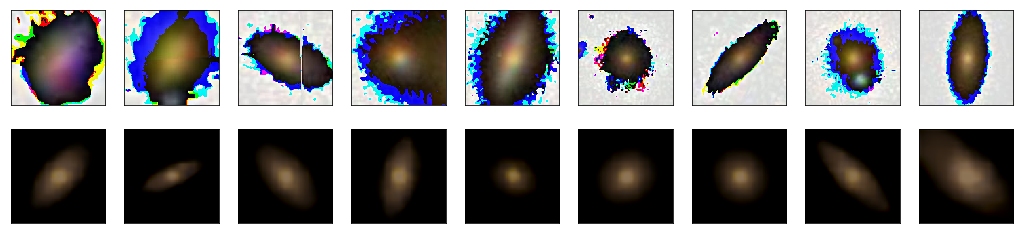

In [67]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
if USE == 'vae':
    decoded_imgs = vae.predict(train_data[1000:1500],batch_size=100)

if USE == 'autoencoder':
    decoded_imgs = autoencoder.predict(train_data[1000:1500],batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

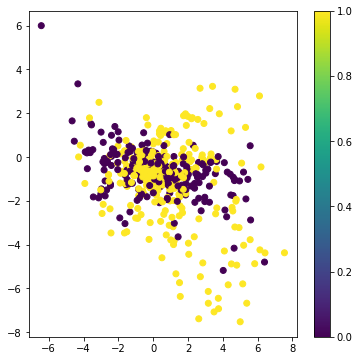

In [68]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] = np.argmax(train_label[i])
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[1000:1500], batch_size=batch_size)  
plt.figure(figsize=(6, 6))  
plt.scatter( x_vis[:, 0] ,x_vis[:, 1], c=label_value[1000:1500])  
plt.colorbar()  
plt.show()

# Results

The code above tried to use AE or VAE to separate different classes into two clusters. VAE works better(but still bad :( ), as is shown above.

The labels of each figure come from civil's votes, e.g.

Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses

So that error also may come from different views. There is no ground truth.